# This Notebook Visualizes the Results.

In [2]:
import json
from functools import partial
from io import StringIO
from operator import itemgetter

from surface_sim.setups.setup import SetupDict

from mccd.random_clifford_circuit import *
from surface_sim.setups import CircuitNoiseSetup
from surface_sim.models import CircuitNoiseModel, BiasedCircuitNoiseModel
from surface_sim import Detectors, Setup
from surface_sim.experiments import schedule_from_circuit, experiment_from_schedule
import time
import stim

from pathlib import Path
import stim
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
from joblib import Parallel, delayed
import itertools
import shelve
from surface_sim.layouts import rot_surface_codes

from pymatching import Matching as MWPM
from mle_decoder import MLEDecoder as MLE
from stimbposd import BPOSD
from sklearn.metrics import accuracy_score


## Baseline Decoders

- MWPM. We use the open-source library PyMatching with the noise model used for data generation as detailed in the ‘Experimentally motivated noise model’ subsection.

- BP-OSD. We use the open-source library stimbposd. We use the exact noise model used for data generation and set the maximal belief propagation iterations to 20.

- MLE. We use the algorithm developed and implemented as in ref. 14.

### Notes

All baselines have PyPI packages.

```
pymatching
mle-decoder
stimbposd
```

## Basic Gates & Surface Code

MCCD uses I, X, Y, Z, H (single qubit gates) and CX (two qubit gates).

MCCD uses Rotated Surface Code.

surface-sim supports I, X, Z for rotated gates and I, H, X, Z for unrotated gates.

### Notes

We use the gates which `surface-sim` supports.

## Circuit Depths

From released source_data.zip, Type I circuits have depths:

array([ 2,  4,  6,  8, 10, 12, 14, 16, 18])

Type II circuits have depths:

array([ 4,  8, 12, 16, 20, 24, 28, 32, 36])


## Noise Model

1. The experimentally motivated noise model, which is the one used in all numerical results in the main text. See Methods section for details.
2. A simplified noise model that replaces all Pauli noise channels, both single-qubit and two-qubit, in the experiment-motivated noise model with a depolarizing noise model using an average noise strength. The probabilities of idling error, reset error, and measurement error remain the same. We refer to this as the average depolarizing noise model.
3. A stronger depolarizing noise model in which the strengths of all noise channels, including single- and two-qubit depolarization, idling error, reset error, and measurement error probability, are doubled compared to the average depolarizing noise model. We refer to this as the double depolarizing noise model.

### Note

1 can only be implemented with `stim`'s builtin instructions like `PAULI_CHANNEL_2` to fill all the parameters.
Or as a custom `Model` of `surface-sim`.

This noise model is used in Results (Fig. 4 & Fig. 5).

2 & 3 can be implemented with `surface-sim`'s `CircuitNoiseModel` with a single `prob` parameter.

The paper does not release the value of the average noise probability. We set it to 1e-3.

### Details of experimentally motivated noise model.

For the numerical studies presented in the ‘Results’ section, we use the stim package for simulation. We consider a circuit-level noise model motivated by the current experimental capability of neutral atom array-based quantum computers. Specifically, we use a circuit-level noise model that includes the following physical noises:

• Each two-qubit physical gate is followed by a two-qubit Pauli noise channel with probability [0.0005, 0.00175, 0.000625, 0.0005, 0, 0, 0, 0.00175, 0, 0, 0, 0.000625, 0, 0, 0.00125]

• Each single-qubit physical gate is followed by a single-qubit depolarizing model with probability [0.0001, 0.0001, 0.0001]

• On a physical level, the atoms are moved to achieve flexible connectivity between different physical qubits. This comes at the cost of having idling error due to the extra time taken during the physical qubit movement, which is captured as a Pauli noise channel with probability [4 × 10−7, 4 × 10−7, 1.6 × 10−6]. This error channel is applied when physical qubit movement happens.

• Resetting a physical qubit has a bit flip error probability of P = 0.002.

• Measuring a physical qubit has a bit flip error probability of P = 0.002.



In [12]:
def load_dataframe(root_dir: Path, df_name: str) -> pd.DataFrame:
    bench_result = list(map(lambda p: json.loads(p.read_text()), root_dir.glob('res*.json')))

    df = pd.DataFrame.from_records(bench_result)
    df = pd.melt(df, id_vars=['decoder', 'distance', 'depth', 'circuit_type_index'],
             value_vars=['walltime_seconds', 'logical_accuracy'],
             var_name='metric',
             value_name='value')

    filename = root_dir / '..' / f'{df_name}.csv'
    filename.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(filename, index=False)
    print('done')
    return df


## Visualization

In [16]:
hue_order = 'MLE BPOSD MWPM'.split()
noise_model = 'average_depolarizing_noise'

### Results on Type I Circuits

In [17]:
df4 = load_dataframe(Path(f'data/bench/{noise_model}/result/fig4-baselines'), 'fig4-baselines')

done


In [18]:
df4.head()

,decoder,distance,depth,circuit_type_index,metric,value
0,MWPM,5,12,3,walltime_seconds,0.021689
1,MLE,3,18,3,walltime_seconds,326.491758
2,MLE,3,2,3,walltime_seconds,24.492846
3,MWPM,3,16,3,walltime_seconds,0.008350
4,MLE,3,6,3,walltime_seconds,96.581184


Text(0.5, 0.98, 'Noise Model: average_depolarizing_noise')

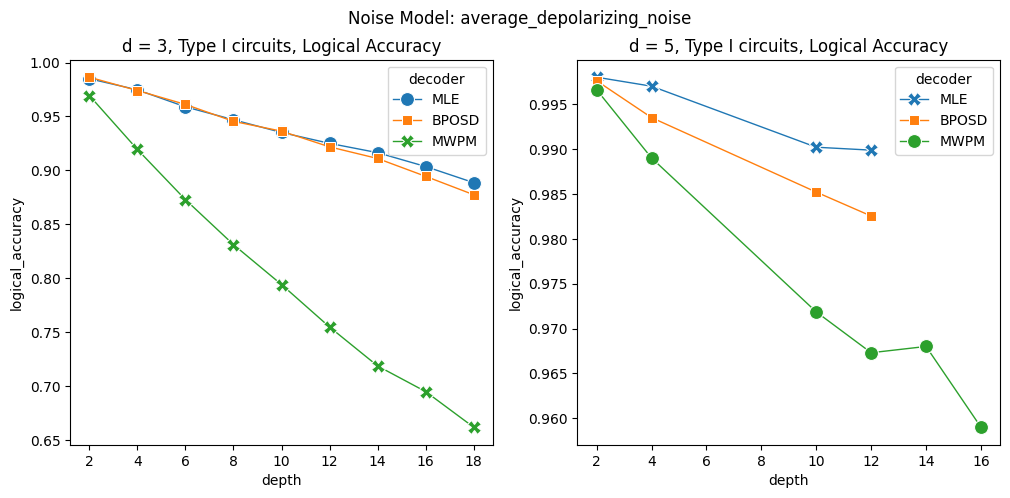

In [19]:
plt.figure(figsize=(12,5))
ax=plt.subplot(121)
sns.lineplot(df4[(df4.metric == 'logical_accuracy') & (df4.distance == 3)], x='depth', y='value', hue='decoder',hue_order=hue_order,
             errorbar=None, style='decoder', markers=True, dashes=False, markersize=10, linewidth=1, ax=ax)
plt.ylabel('logical_accuracy')
plt.title('d = 3, Type I circuits, Logical Accuracy')

ax=plt.subplot(122)
sns.lineplot(df4[(df4.metric == 'logical_accuracy') & (df4.distance == 5)], x='depth', y='value', hue='decoder',hue_order=hue_order,
             errorbar=None, style='decoder', markers=True, dashes=False, markersize=10, linewidth=1, ax=ax)
plt.ylabel('logical_accuracy')
plt.title('d = 5, Type I circuits, Logical Accuracy')
plt.suptitle(f'Noise Model: {noise_model}')


Compared with Fig. 4, the range of decrease is much smaller for Type I Circuits.
However, our decrease ranges on Type I Circuits are still smaller than on Type II Circuits, which is similar to Fig. 4 and Fig. 5.

The performances of different decoders are also closer than Fig. 4.

The relative order is not well-preserved because they are nearly the same for each depth.

Text(0.5, 0.98, 'Noise Model: average_depolarizing_noise')

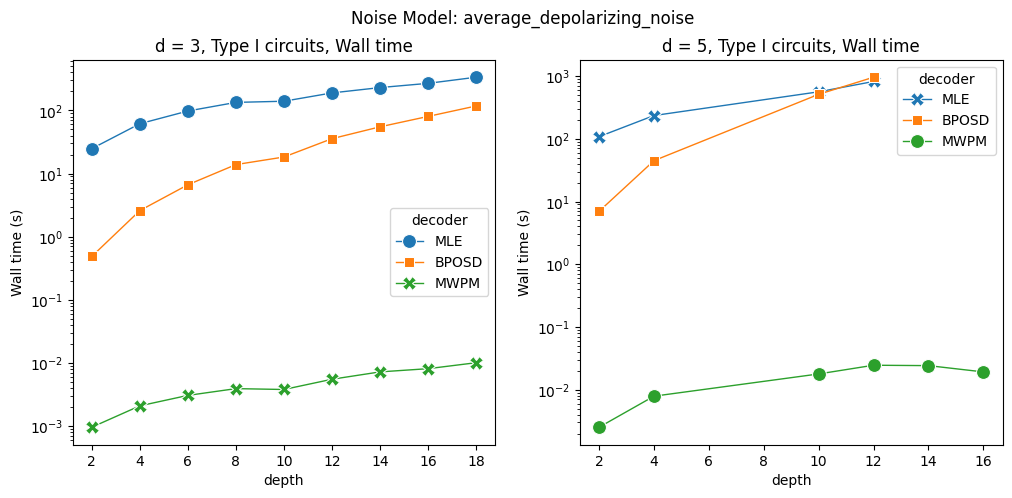

In [20]:
plt.figure(figsize=(12,5))
ax=plt.subplot(121)

sns.lineplot(df4[(df4.metric == 'walltime_seconds') & (df4.distance == 3)], x='depth', y='value', hue='decoder', hue_order=hue_order,
             errorbar=None, style='decoder', markers=True, dashes=False, markersize=10, linewidth=1, ax=ax)
plt.ylabel('Wall time (s)')
plt.yscale('log')
plt.title('d = 3, Type I circuits, Wall time')

ax=plt.subplot(122)
sns.lineplot(df4[(df4.metric == 'walltime_seconds') & (df4.distance == 5)], x='depth', y='value', hue='decoder', hue_order=hue_order,
             errorbar=None, style='decoder', markers=True, dashes=False, markersize=10, linewidth=1, ax=ax)
plt.ylabel('Wall time (s)')
plt.yscale('log')
plt.title('d = 5, Type I circuits, Wall time')
plt.suptitle(f'Noise Model: {noise_model}')


Compared with Fig. 4, our wall time in seconds are faster for Type I but slower for Type II.

The trend of longer time for deeper circuits are less clear than Fig. 4.

The relative order of baseline methods is preserved: MLE > BPOSD > MWPM.

### Results on Type II Circuits

In [ ]:
df5 = pd.read_csv(f'./data/bench/{noise_model.__name__}/fig5.csv')


In [ ]:
plt.figure(figsize=(12,5))
ax=plt.subplot(121)
sns.lineplot(df5[(df5.metric == 'logical_accuracy') & (df5.distance == 3)], x='depth', y='value', hue='decoder', hue_order=hue_order,
             errorbar=None, style='decoder', markers=True, dashes=False, markersize=10, linewidth=1, ax=ax)
plt.ylabel('logical_accuracy')

plt.title('d = 3, Type II circuits, Logical Accuracy')
ax=plt.subplot(122)
sns.lineplot(df5[(df5.metric == 'logical_accuracy') & (df5.distance == 5)], x='depth', y='value', hue='decoder', hue_order=hue_order,
             errorbar=None, style='decoder', markers=True, dashes=False, markersize=10, linewidth=1, ax=ax)
plt.ylabel('logical_accuracy')

plt.title('d = 5, Type II circuits, Logical Accuracy')
plt.suptitle(f'Noise Model: {noise_model.__name__}')

Compared to Fig. 5, the relative order of decoders is preserved: MLE >= BPOSD >= MWPM.

The range of logical accuracy as the depth increases is also very close to that of Fig. 5.

The lower bounds of logical accuracy in Fig. 5 are about 10% better than ours for both d = 3 and d = 5.

The upper bounds of both ours and Fig. 5 are nearly the same: close to 100%.


In [ ]:
plt.figure(figsize=(12,5))
ax=plt.subplot(121)
sns.lineplot(df5[(df5.metric == 'walltime_seconds') & (df5.distance == 3)], x='depth', y='value', hue='decoder', hue_order=hue_order,
             errorbar=None, style='decoder', markers=True, dashes=False, markersize=10, linewidth=1, ax=ax)
plt.ylabel('Wall time (s)')
plt.yscale('log')
# plt.ylim(1e-3, 10)
plt.title('d = 3, Type II circuits, Wall time')
ax=plt.subplot(122)
sns.lineplot(df5[(df5.metric == 'walltime_seconds') & (df5.distance == 5)], x='depth', y='value', hue='decoder', hue_order=hue_order,
             errorbar=None, style='decoder', markers=True, dashes=False, markersize=10, linewidth=1, ax=ax)
plt.ylabel('Wall time (s)')
plt.yscale('log')
# plt.ylim(1e-3, 10)
plt.title('d = 5, Type II circuits, Wall time')
plt.suptitle(f'Noise Model: {noise_model.__name__}')

Again, the relative order is preserved: MLE > BPOSD > MWPM.

The trend of increasing wall time in seconds is also nearly the same.

The absolute ranges of wall time for each decoder are quite different.

## Conclusion

### Pros
1. Overall trends are reproduced.
    - Increasing wall time as the depth increases.
    - Decreasing logical accuracy as the depth increases.
2. Overall relative orders of different decoders are reproduced.
    - For logical accuracy, MLE > BPOSD > MWPM.
    - For wall time, MLE > BPOSD > MWPM.

### Cons
1. Absolute value ranges are not reproduced.
2. MCCD is not reproduced.
3. The experimental noise model is not reproduced.